# Time to get your hands dirty! Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at [https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt](https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt)
- You can find the physical meaning of each variable at [https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html](https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html)

This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the techniques we have seen in classes so far, etc. **Be creative! You're discovering**

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?


In [15]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

/tmp/ipykernel_2942/3291602058.py:7: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [3]:
#Extract numerical arrays from the dataset for analysis: T90 duration and its error, fluence and its error, and redshift
T90=np.array(data[6],dtype=float)
T90err=np.array(data[7],dtype=float)
fluence=np.array(data[9],dtype=float)
fluencererr=np.array(data[10],dtype=float)
redshift = np.array(data[11], dtype=float)

In [4]:
datanew = np.column_stack((T90, fluence)) 
mask = ~(datanew == -999).any(axis=1) # Create a boolean mask that identifies rows which do NOT contain the value -999

datanew_c = datanew[mask] # Apply the mask to keep only the valid rows (those without -999)
print(datanew_c.shape)


(7550, 2)


In [5]:
# Create a boolean mask to select rows where both T90 and fluence are greater than 0 ( in order to apply logarithm)
valid_mask = (datanew_c[:, 0] > 0) & (datanew_c[:, 1] > 0)
T90log = np.log10(datanew_c[:, 0][valid_mask])  
Fluencelog = np.log10(datanew_c[:, 1][valid_mask])  

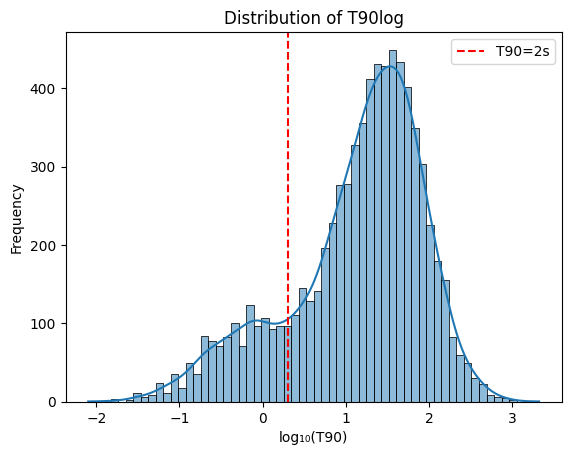

In [22]:
# Plot histogram of log10(T90) 
sns.histplot(T90log, bins=60, kde=True, edgecolor='black')
# Add vertical dashed red line at log10(2) to mark the boundary between short and long GRBs
plt.axvline(np.log10(2), color='red', linestyle='--', label='T90=2s') 
plt.xlabel('log₁₀(T90)')
plt.ylabel('Frequency')
plt.title('Distribution of T90log')
plt.legend()

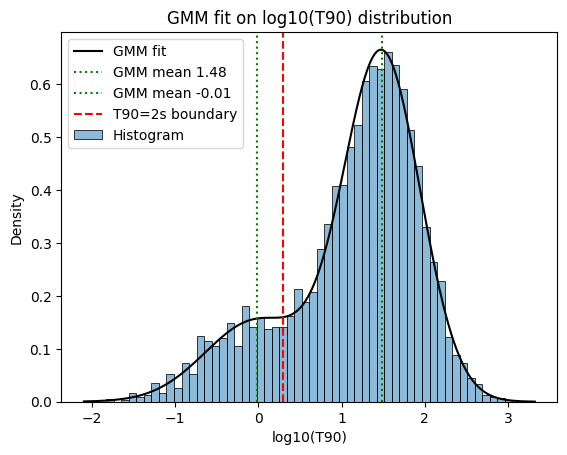

In [23]:
# Fit a Gaussian Mixture Model with 2 components
T90log= T90log.reshape(-1, 1)  # GMM expects 2D input
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(T90log)

means= np.squeeze(gmm.means_)

xgrid = np.linspace(T90log.min(), T90log.max(), 1000).reshape(-1,1)
prob = gmm.score_samples(xgrid)
pdf = np.exp(prob) #compute the pdf for each point in the grid

sns.histplot(T90log, bins=60, stat='density', edgecolor='black', alpha=0.5, label='Histogram')
plt.plot(xgrid, pdf, 'k-', label='GMM fit')

#Plot vertical lines at the means of the Gaussian components
for m in means:
    plt.axvline(m, color='green', linestyle='dotted', label=f'GMM mean {m:.2f}')
plt.axvline(np.log10(2), color='red', linestyle='--', label='T90=2s boundary')

plt.xlabel('log10(T90)')
plt.ylabel('Density')
plt.title('GMM fit on log10(T90) distribution')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Distribution of Fluencelog')

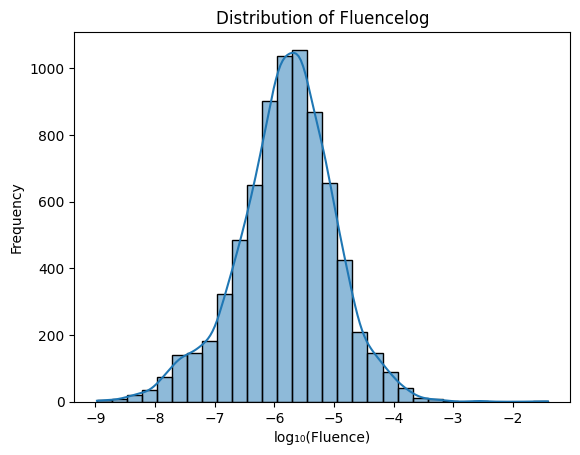

In [7]:
# Plot histogram of log10(Fluence)
sns.histplot(Fluencelog, bins=30, kde=True, edgecolor='black')
plt.xlabel('log₁₀(Fluence)')
plt.ylabel('Frequency')
plt.title('Distribution of Fluencelog')

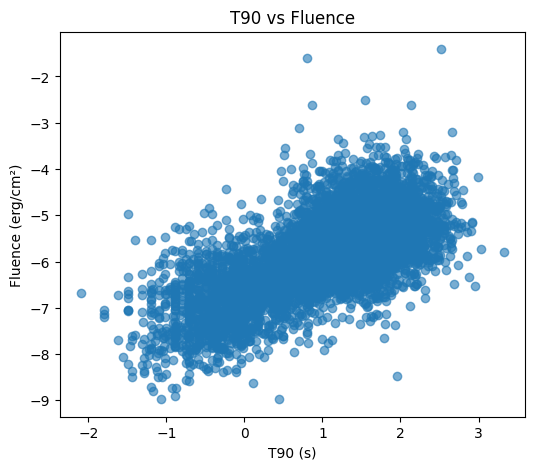

In [11]:
# Plot the log scatter plot of T90 vs fluence
plt.figure(figsize=(6,5))
plt.scatter(T90log, Fluencelog, alpha=0.6)
plt.xlabel("T90 (s)")
plt.ylabel("Fluence (erg/cm²)")
plt.title("T90 vs Fluence")
plt.show()

In [14]:
X = np.column_stack((T90log, Fluencelog))
clf = KMeans(n_clusters=2,n_init='auto') # Initialize KMeans with 2 clusters
clf.fit(X)
centers = clf.cluster_centers_
labels = clf.predict(X) # Predict cluster labels for each point
print("Cluster centers:\n", centers)

Cluster centers:
 [[ 1.52298298 -5.45848196]
 [ 0.05997406 -6.71944534]]


Text(0.5, 1.0, 'Clustering output')

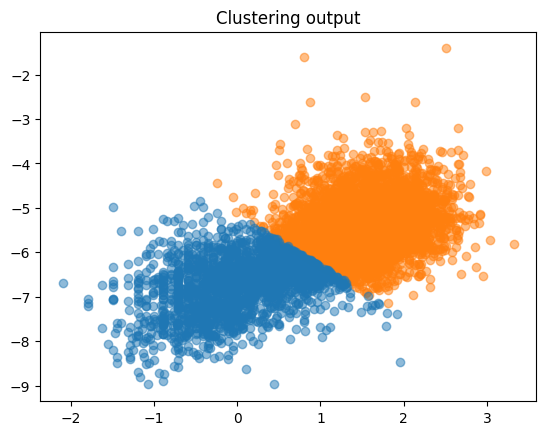

In [9]:
# Plot points color-coded by cluster assignment
colors = ['C1', 'C0']
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)

plt.title('Clustering output')

In [11]:
# Calculate the silhouette score for KMeans clustering with 2 to 6 clusters
for n_clusters in range(2, 7):
    clf = KMeans(n_clusters=n_clusters, n_init='auto')
    clf.fit(X)
    
    # Predict labels for the current clustering
    labels = clf.predict(X)
    sil_score = silhouette_score(X, labels)
    
    print(f"\nSilhouette Score for {n_clusters} clusters: {sil_score:.4f}")



Silhouette Score for 2 clusters: 0.5176

Silhouette Score for 3 clusters: 0.3854

Silhouette Score for 4 clusters: 0.3398

Silhouette Score for 5 clusters: 0.3187

Silhouette Score for 6 clusters: 0.3216


### Silhouette Score

The Silhouette Score is a metric used to evaluate the quality of a clustering result. It measures how well each point fits within its own cluster compared to other clusters.

For each point:
- **a(i)** is the average distance to other points in the same cluster.
- **b(i)** is the average distance to points in the nearest different cluster.

The score is calculated as:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$


In [30]:
X = np.column_stack((T90log, Fluencelog))
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)# Standardize the data (mean = 0, std = 1)
bandwidth_value = 0.4
ms = MeanShift(bandwidth=bandwidth_value, bin_seeding=True, cluster_all=True) # Initialize and fit the MeanShift model
ms.fit(X_scaled)

labels_ms = ms.labels_  # Get the labels assigned to each data point
centers_ms = ms.cluster_centers_  # Get the coordinates of the cluster centers


Text(0.5, 1.0, 'Mean-Shift Clustering: T90 vs Fluence (scaled) - Bandwidth 0.40')

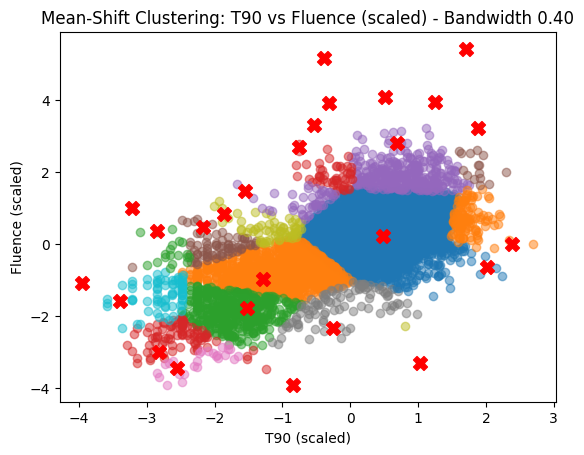

In [31]:
unique_labels = np.unique(labels_ms) # Get the unique cluster labels

# Scatter plot the points of each cluster, using a different color for each cluster
for label in unique_labels:
    plt.scatter(X_scaled[labels_ms == label, 0], X_scaled[labels_ms == label, 1], 
                alpha=0.5, label=f'Cluster {label+1}')

# Plot the centers of the clusters
plt.scatter(centers_ms[:, 0], centers_ms[:, 1], s=100, c='red', marker='X', label='Cluster Centers')

plt.xlabel('T90 (scaled)')
plt.ylabel('Fluence (scaled)')
plt.title(f"Mean-Shift Clustering: T90 vs Fluence (scaled) - Bandwidth {bandwidth_value:.2f}")

We can observe an important aspect regarding outliers:

In the KMeans algorithm, we specify the number of clusters in advance. Outliers are generally ignored because the algorithm focuses on minimizing the distance within the main groups of data. As a result, outliers typically do not form their own clusters and have little influence on the final clustering.

In contrast, with the Mean Shift algorithm, if a point is far from other points, it can become its own cluster. This happens because Mean Shift finds regions of high data density by shifting points toward the mean of their local neighborhood. If a point is isolated and no other points fall within the bandwidth, it will form a separate cluster.